In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pybioclip

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bioclip import CustomLabelsClassifier
import geopandas as gpd
import seaborn as sns

# Paths to the invasive and native datasets
invasive_dataset_path = '/content/drive/MyDrive/AI4C/Final_Project/northeast_invasive_insects.csv'
native_dataset_path = '/content/drive/MyDrive/AI4C/Final_Project/northeast_native_insects.csv'

# Load the datasets
invasive_df = pd.read_csv(invasive_dataset_path)
native_df = pd.read_csv(native_dataset_path)

# Combine invasive and native datasets- they have now been re-exported to have identical labels and more geospatial labels, and range was expanded to northeast region of U.S
combined_df = pd.concat([invasive_df, native_df], ignore_index=True)

# Define the list of species to focus on
species_list = [
    "Lymantria dispar", "Agrilus planipennis", "Popillia japonica", "Lycorma delicatula", "Adelges tsugae", # invasive species
    "Malacosoma americana", "Cicindela sexguttata", "Cotinis nitida", "Jikradia olitoria", "Chinavia hilaris"  # native species
]

# Filter the combined dataset to include only the specified species
filtered_df = combined_df[combined_df['taxon_species_name'].isin(species_list)]

Species distribution across both datasets:
taxon_species_name
Lycorma delicatula      36731
Lymantria dispar        15888
Popillia japonica       12978
Malacosoma americana    10832
Cicindela sexguttata     9248
Chinavia hilaris         7545
Cotinis nitida           3913
Jikradia olitoria        2837
Adelges tsugae           2721
Agrilus planipennis      1272
Name: count, dtype: int64


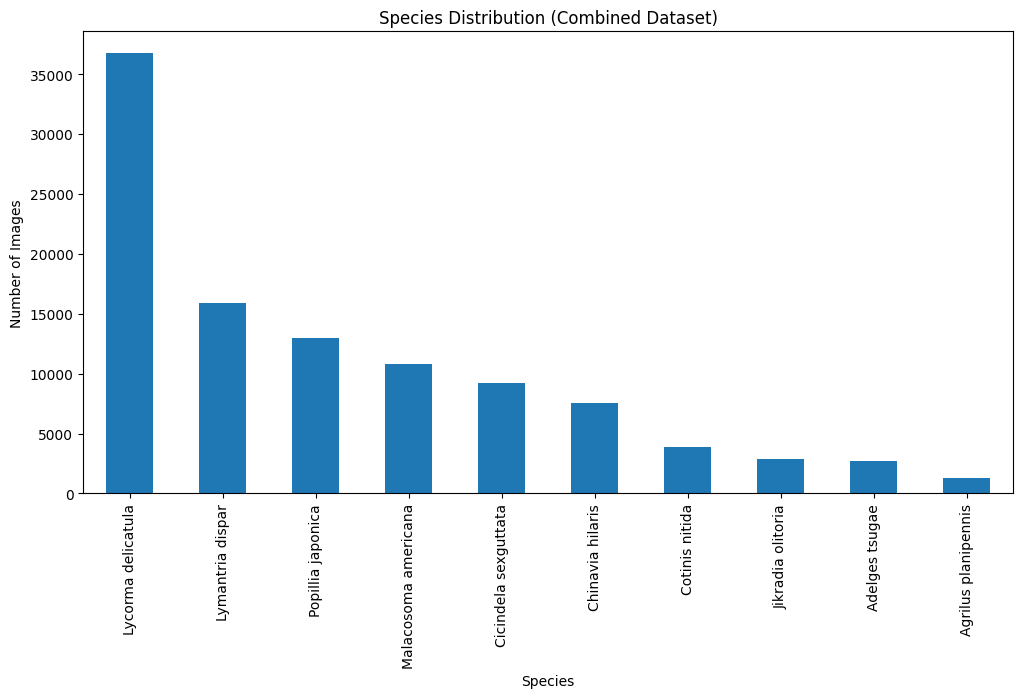

In [4]:
# Print dataset statistics
species_counts = filtered_df['taxon_species_name'].value_counts()
print("Species distribution across both datasets:")
print(species_counts)

# Visualize the species distribution
species_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Species Distribution (Combined Dataset)')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.show()

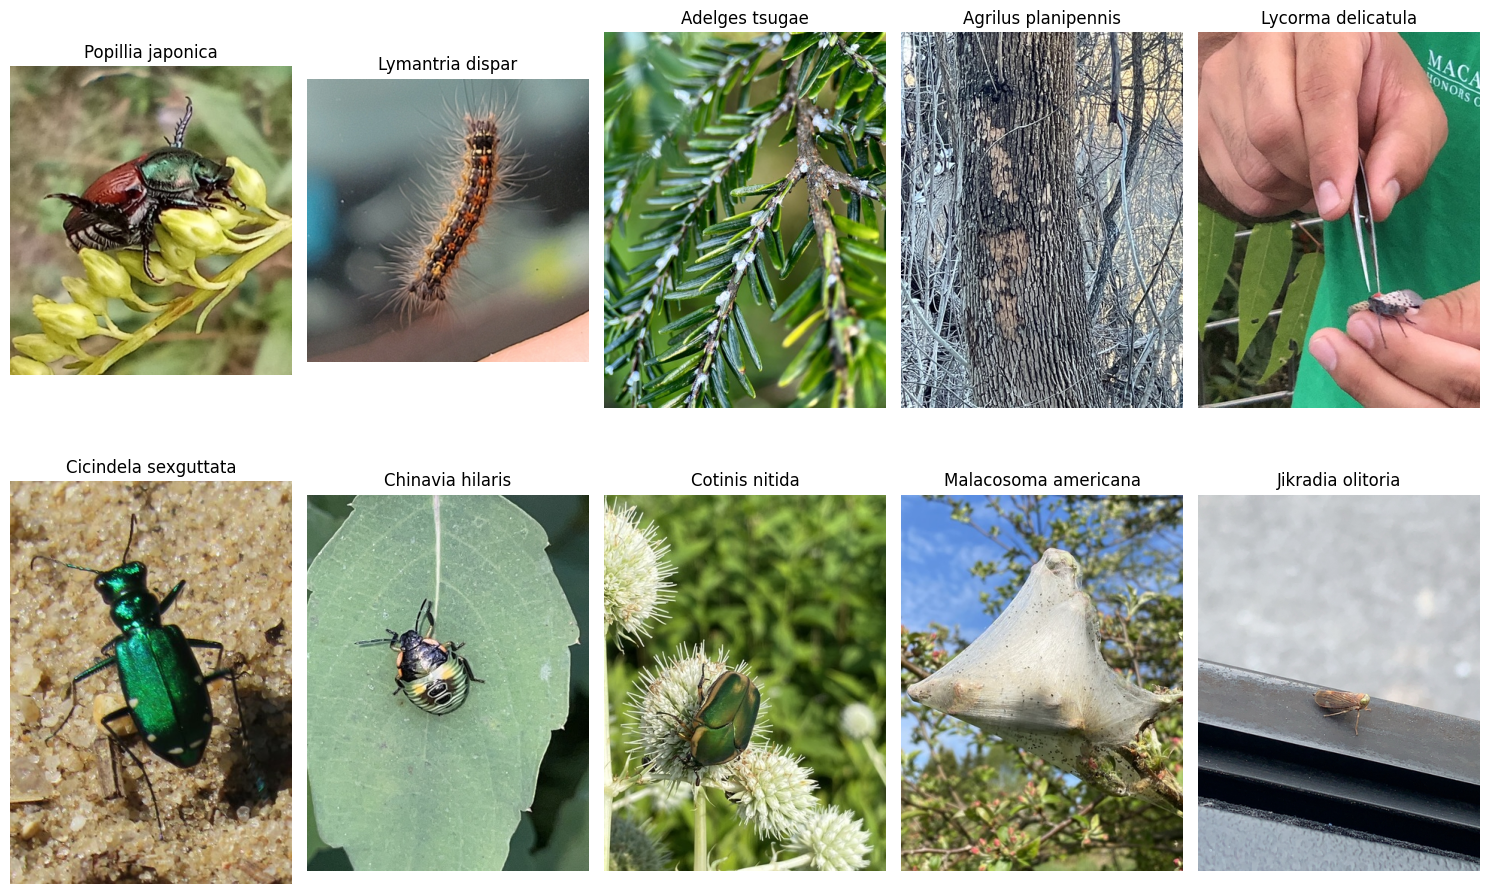

In [5]:
# Display sample image of each species
species_list = filtered_df['taxon_species_name'].unique()

plt.figure(figsize=(15, 10))
cols = 5
rows = (len(species_list) + cols - 1) // cols

for i, sp in enumerate(species_list, 1):
    row = filtered_df[filtered_df['taxon_species_name'] == sp].sample(1).iloc[0]
    resp = requests.get(row.image_url)
    img = Image.open(BytesIO(resp.content))
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(sp)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Set a ceiling for the number of images per species
ceiling = 1272 # minimum species count
limited_metadata = pd.DataFrame()

for species in species_list:
    species_data = filtered_df[filtered_df['taxon_species_name'] == species]
    if len(species_data) > ceiling:
        species_data = species_data.sample(n=ceiling, random_state=42)
    limited_metadata = pd.concat([limited_metadata, species_data])

limited_metadata.reset_index(drop=True, inplace=True)

# Print species distribution after limiting dataset size
print("Species distribution after limiting the dataset:")
print(limited_metadata['taxon_species_name'].value_counts())

Species distribution after limiting the dataset:
taxon_species_name
Popillia japonica       1272
Lymantria dispar        1272
Adelges tsugae          1272
Agrilus planipennis     1272
Lycorma delicatula      1272
Cicindela sexguttata    1272
Chinavia hilaris        1272
Cotinis nitida          1272
Malacosoma americana    1272
Jikradia olitoria       1272
Name: count, dtype: int64


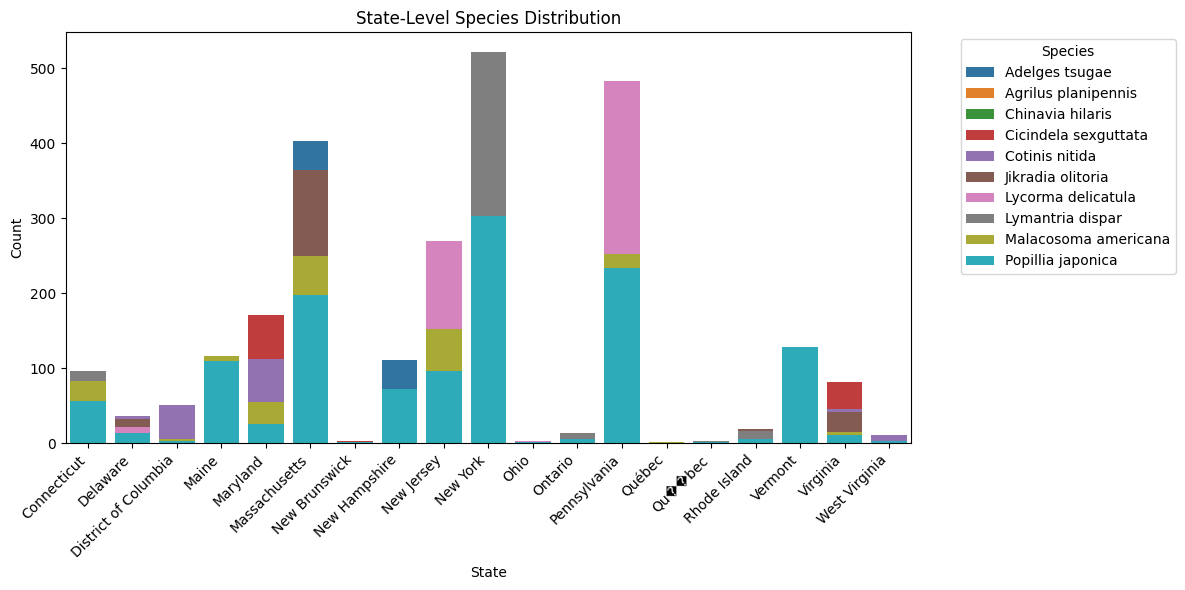

In [7]:
# Generate state and county-level statistics
state_counts = limited_metadata.groupby(['place_state_name', 'taxon_species_name']).size().reset_index(name='count')
county_counts = limited_metadata.groupby(['place_county_name', 'place_state_name', 'taxon_species_name']).size().reset_index(name='count')

# Plot state-level distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=state_counts, x='place_state_name', y='count', hue='taxon_species_name', dodge=False)
plt.title('State-Level Species Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

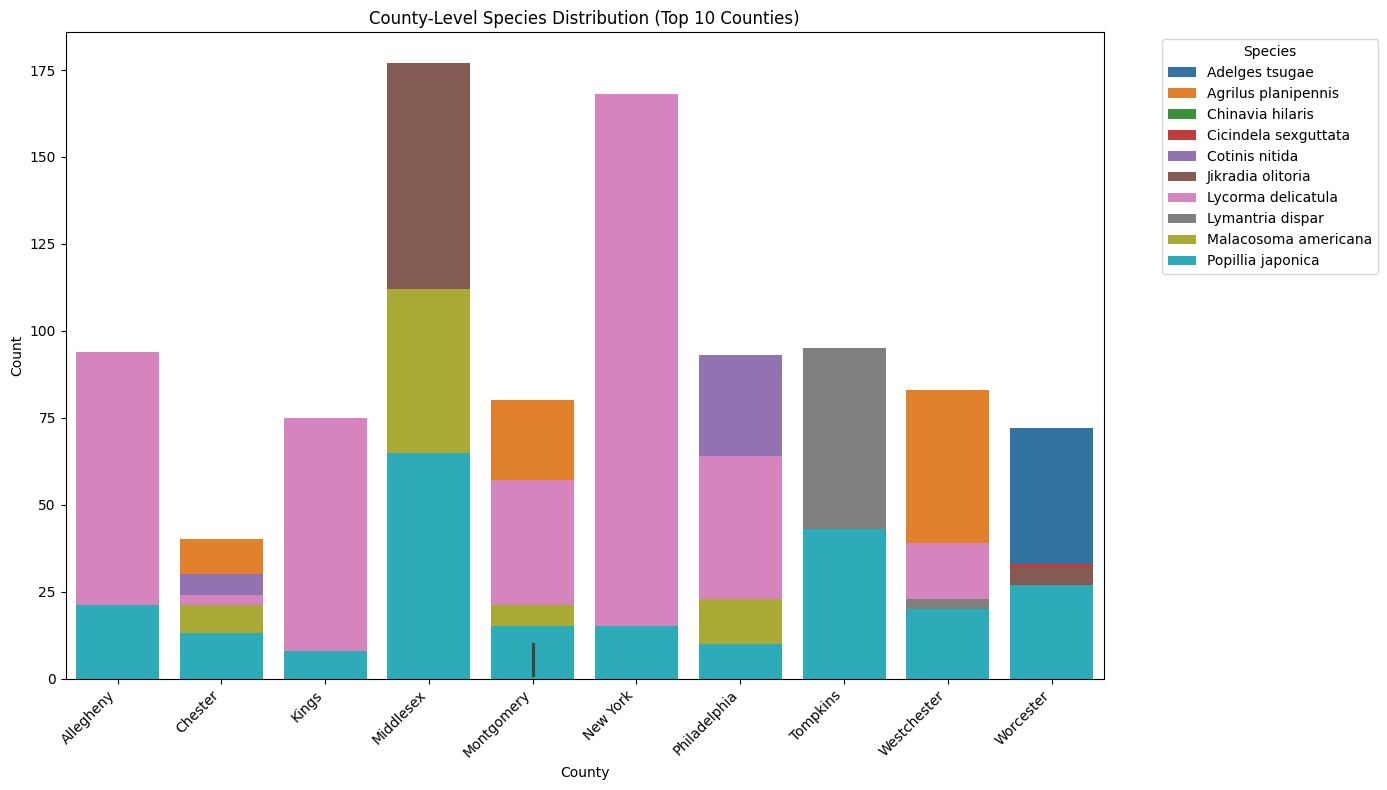

In [8]:
# Plot county-level distribution for the top 10 counties with the most species occurrences
top_counties = county_counts.groupby(['place_county_name', 'place_state_name'])['count'].sum().nlargest(10).reset_index()
filtered_county_counts = county_counts[
    (county_counts['place_county_name'].isin(top_counties['place_county_name'])) &
    (county_counts['place_state_name'].isin(top_counties['place_state_name']))
]

plt.figure(figsize=(14, 8))
sns.barplot(
    data=filtered_county_counts,
    x='place_county_name',
    y='count',
    hue='taxon_species_name',
    dodge=False
)
plt.title('County-Level Species Distribution (Top 10 Counties)')
plt.xlabel('County')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Save temporary image path for predictions
temp_image_path = r'C:\aiforcon\finalproj\temp_image.jpg'

# Initialize the classifier
custom_classifier = CustomLabelsClassifier(species_list)

# Define performance tracking dictionary
performance = {
    "y_true": [],
    "y_pred": [],
    "image_url": []
}

# Function to download and open an image from a URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to load image from {url}: {e}")
        return None

# Process each image in the dataset
for _, row in tqdm(limited_metadata.iterrows(), total=len(limited_metadata), desc="Processing Images"):
    image_url = row['image_url']
    ground_truth = row['taxon_species_name']

    # Load image from URL
    image = load_image_from_url(image_url)
    if image is None:
        continue  # Skip if image loading failed

    image = image.convert('RGB')

    # Save image temporarily
    image.save(temp_image_path)

    # Predict using CustomLabelsClassifier
    prediction = custom_classifier.predict(temp_image_path)
    predicted_species = prediction[0]['classification'] if prediction else None

    # Store predictions and ground truths for metric calculation
    performance["y_true"].append(ground_truth)
    performance["y_pred"].append(predicted_species)
    performance["image_url"].append(image_url)

In [ ]:
# Calculate and display performance metrics
accuracy = accuracy_score(performance["y_true"], performance["y_pred"]) * 100
precision = precision_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
recall = recall_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
f1 = f1_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100

print(f"\nBaseline Performance Metrics with CustomLabelsClassifier:\n"
      f"  Accuracy: {accuracy:.2f}%\n"
      f"  Precision: {precision:.2f}%\n"
      f"  Recall: {recall:.2f}%\n"
      f"  F1 Score: {f1:.2f}%")


Baseline Performance Metrics with CustomLabelsClassifier:
  Accuracy: 95.14%
  Precision: 95.16%
  Recall: 95.14%
  F1 Score: 95.13%



Failed Predictions:
                  y_true               y_pred  \
1      Popillia japonica       Cotinis nitida   
17     Popillia japonica    Jikradia olitoria   
22     Popillia japonica       Cotinis nitida   
26     Popillia japonica       Cotinis nitida   
52     Popillia japonica       Cotinis nitida   
...                  ...                  ...   
12568  Jikradia olitoria   Lycorma delicatula   
12571  Jikradia olitoria   Lycorma delicatula   
12604  Jikradia olitoria    Popillia japonica   
12616  Jikradia olitoria    Popillia japonica   
12618  Jikradia olitoria  Agrilus planipennis   

                                               image_url  
1      https://inaturalist-open-data.s3.amazonaws.com...  
17     https://inaturalist-open-data.s3.amazonaws.com...  
22     https://inaturalist-open-data.s3.amazonaws.com...  
26     https://inaturalist-open-data.s3.amazonaws.com...  
52     https://static.inaturalist.org/photos/40547455...  
...                                 

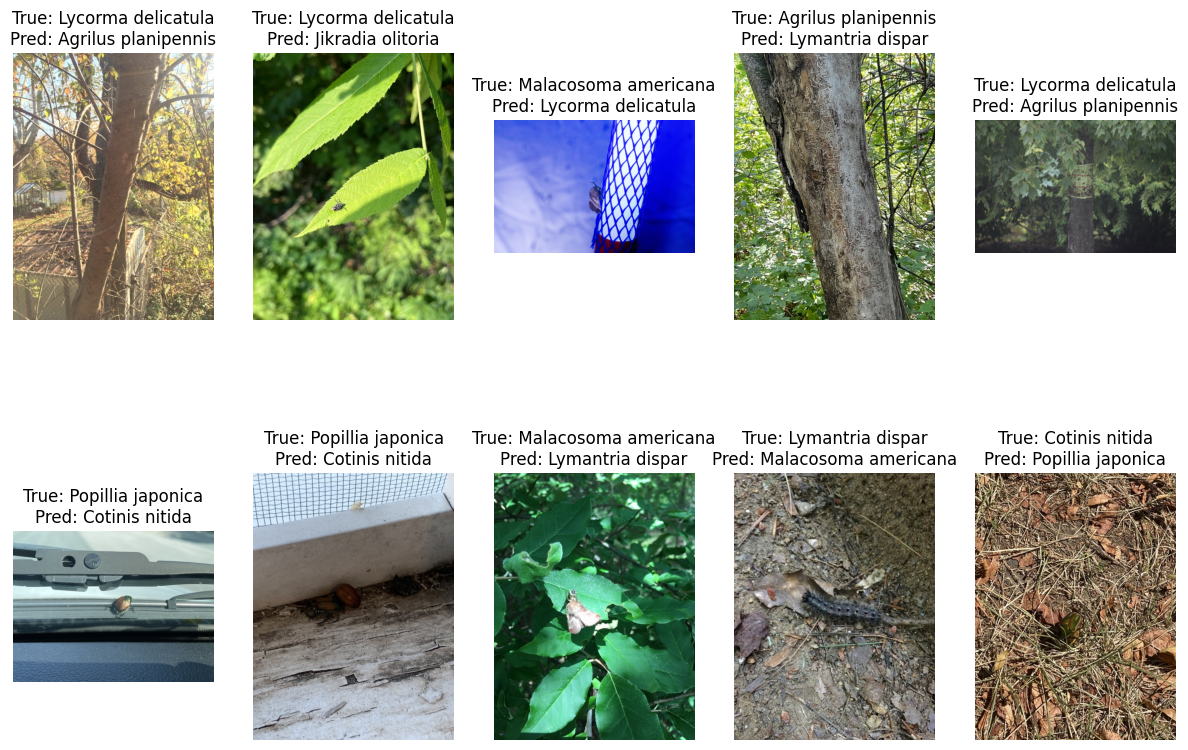

In [ ]:
# Identify failed predictions
failed_predictions = pd.DataFrame({
    "y_true": performance["y_true"],
    "y_pred": performance["y_pred"],
    "image_url": performance["image_url"]
})
failed_predictions = failed_predictions[failed_predictions["y_true"] != failed_predictions["y_pred"]]

# Display failed predictions
print("\nFailed Predictions:")
print(failed_predictions)

# Visualize failed prediction images
if not failed_predictions.empty:
    failed_images = failed_predictions.sample(min(10, len(failed_predictions)))
    plt.figure(figsize=(15, 10))
    for i, row in enumerate(failed_images.itertuples(), 1):
        response = requests.get(row.image_url)
        img = Image.open(BytesIO(response.content))
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.title(f"True: {row.y_true}\nPred: {row.y_pred}")
        plt.axis('off')
    plt.show()